In [1]:
import torch
import torch.nn as nn

### Define activation functions

In [3]:
activation_functions = {
    "ReLU": nn.ReLU(),
    "Leaky ReLU": nn.LeakyReLU(0.01),
    "PReLU": nn.PReLU(),
    "RReLU": nn.RReLU(0.1, 0.3),
    "ELU": nn.ELU(),
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
}

### Preprocessing MNIST Dataset

In [5]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

### Load MNIST Dataset

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

### Neural Network

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, activation):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.activation = activation
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # No activation in output (CrossEntropyLoss includes softmax)
        return x

### Training and Evaluation Function

In [11]:
import torch.optim as optim
import time

def train_and_evaluate(activation_name, activation_fn):
    model = SimpleNN(activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    start_time = time.time()
    for epoch in range(5):  # Train for 5 epochs
        model.train()
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    training_time = time.time() - start_time

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return training_time, accuracy

### Run Experiments for Different Activation Functions

In [13]:
results = {}
for name, func in activation_functions.items():
    print(f"Training with {name} activation...")
    time_taken, acc = train_and_evaluate(name, func)
    results[name] = {"Time (s)": round(time_taken, 2), "Accuracy (%)": round(acc, 2)}

Training with ReLU activation...
Training with Leaky ReLU activation...
Training with PReLU activation...
Training with RReLU activation...
Training with ELU activation...
Training with Sigmoid activation...
Training with Tanh activation...


In [14]:
print("\n📊 Comparison of Activation Functions:\n")
for name, res in results.items():
    print(f"{name}: Time = {res['Time (s)']}s, Accuracy = {res['Accuracy (%)']}%")


📊 Comparison of Activation Functions:

ReLU: Time = 123.17s, Accuracy = 97.31%
Leaky ReLU: Time = 120.42s, Accuracy = 97.45%
PReLU: Time = 122.53s, Accuracy = 97.12%
RReLU: Time = 122.66s, Accuracy = 97.08%
ELU: Time = 120.66s, Accuracy = 97.39%
Sigmoid: Time = 119.47s, Accuracy = 97.08%
Tanh: Time = 122.19s, Accuracy = 96.52%


### Visualizing the result 

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
def plot_activation_results(results):
    """Generates visual comparisons for different activation functions."""
    activation_names = list(results.keys())
    accuracy = [results[act]["Accuracy (%)"] for act in activation_names]
    training_time = [results[act]["Time (s)"] for act in activation_names]

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Bar plot for Accuracy
    sns.barplot(x=activation_names, y=accuracy, hue=activation_names, palette="Blues", legend=False, ax=axes[0])
    axes[0].set_title("Activation Function vs Accuracy")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_xticks(range(len(activation_names)))  # Ensure tick positions are set
    axes[0].set_xticklabels(activation_names, rotation=45)

    # Bar plot for Training Time
    sns.barplot(x=activation_names, y=training_time, hue=activation_names, palette="Reds", legend=False, ax=axes[1])
    axes[1].set_title("Activation Function vs Training Time")
    axes[1].set_ylabel("Training Time (s)")
    axes[1].set_xticks(range(len(activation_names)))  
    axes[1].set_xticklabels(activation_names, rotation=45)

    # Scatter plot for Accuracy vs Training Time
    sns.scatterplot(x=training_time, y=accuracy, hue=activation_names, palette="viridis", s=100, ax=axes[2])
    axes[2].set_title("Accuracy vs Training Time Trade-off")
    axes[2].set_xlabel("Training Time (s)")
    axes[2].set_ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

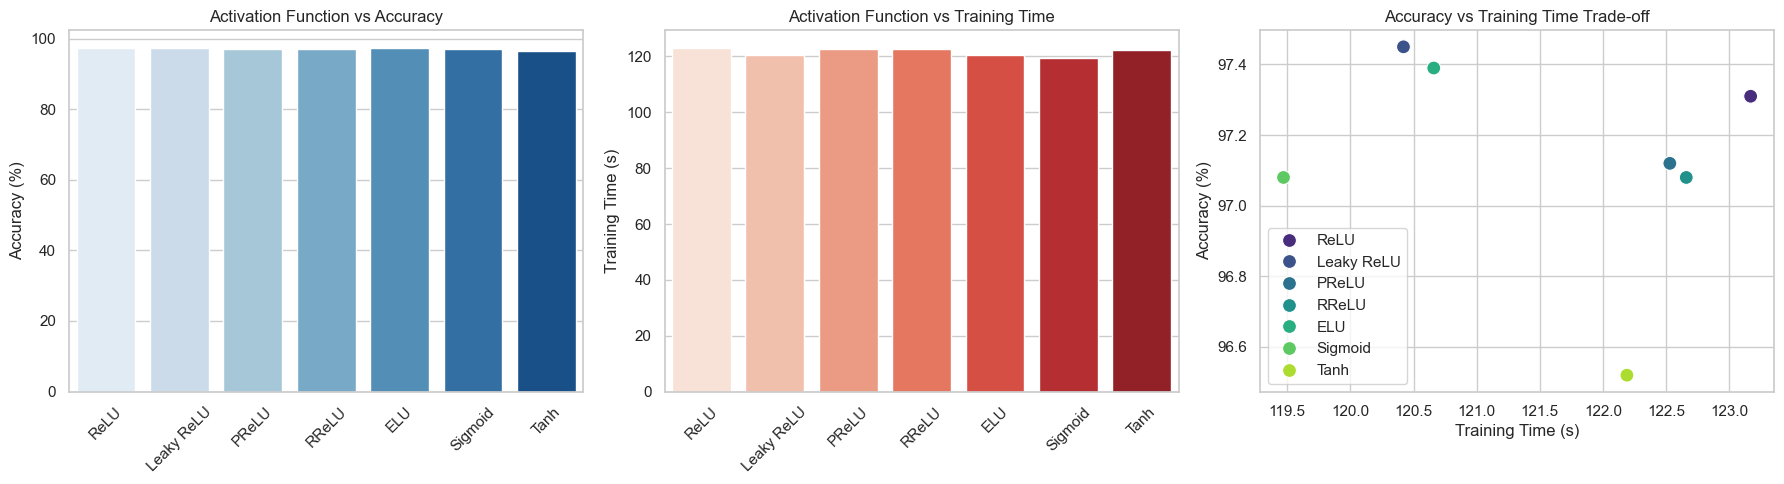

In [40]:
plot_activation_results(results)

### Insights from Activation Function Performance on MNIST Dataset

#### 1️ Performance Insights  
- **Leaky ReLU** achieved the **highest accuracy (97.45%)**, slightly outperforming ReLU and ELU.  
- **ReLU (97.31%)** and **ELU (97.39%)** performed very similarly, showing that these activation functions work well for MNIST.  
- **PReLU and RReLU** had slightly lower accuracy (**~97.1%**), suggesting that **learnable and randomized negative slopes** didn't improve much in this case.  
- **Tanh had the lowest accuracy (96.52%)**, likely due to its **vanishing gradient issue**.  

#### 2️ Training Time Analysis  
- **Sigmoid had the shortest training time (119.47s)**, but it performed worse (**97.08%**) due to **saturation effects**.  
- **Leaky ReLU trained slightly faster (120.42s)** while achieving the **highest accuracy**.  
- **ReLU had the longest training time (123.17s)**, possibly due to **dead neurons slowing down backpropagation**.  

#### 3️ Key Takeaways  
- **Leaky ReLU > ReLU > ELU for MNIST** (**highest accuracy + faster training**).  
- **Tanh and Sigmoid underperformed**, reinforcing that they are **not ideal for deep networks**.  
- **ReLU still remains a strong baseline**, but **Leaky ReLU may be slightly better**.  
- **ELU performed well** and might be useful for **more complex datasets** where **zero-centered activations help**.  